In [21]:

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import joblib
from google.cloud import aiplatform
from sklearn.pipeline import Pipeline
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, GridSearchCV
import numpy as np

In [22]:
file_path_test = 'medical_cases_test.csv'
df_test = pd.read_csv(file_path_test)
print("✅ Successfully loaded the test dataset.")
print("Dataset preview:")
print(df_test.head())

file_path_train = 'medical_cases_train.csv'
df_train = pd.read_csv(file_path_train)
print("✅ Successfully loaded the train dataset.")
print("Dataset preview:")
print(df_train.head())

file_path_validation = 'medical_cases_validation.csv'
df_validation = pd.read_csv(file_path_validation)
print("✅ Successfully loaded the validation dataset.")
print("Dataset preview:")
print(df_validation.head())

✅ Successfully loaded the test dataset.
Dataset preview:
                                         description  \
0  Complete laminectomy, L4. and facetectomy, L3-...   
1  Loculated left effusion, multilobar pneumonia....   
2  Abnormal echocardiogram findings and followup....   
3  Application of PMT large halo crown and vest. ...   
4  MRI Brain & MRI C-T spine: Multiple hemangiobl...   

                                       transcription  \
0  PREOPERATIVE DIAGNOSIS:,  Dural tear, postoper...   
1  REASON FOR CONSULTATION: , Loculated left effu...   
2  REASON FOR CONSULTATION:  ,Abnormal echocardio...   
3  PREOPERATIVE DIAGNOSES: , Cervical spondylosis...   
4  CC:, Weakness.,HX:, This 30 y/o RHM was in goo...   

                 sample_name           medical_specialty  \
0  Laminectomy & Facetectomy                  Orthopedic   
1       Multilobar Pneumonia  Cardiovascular / Pulmonary   
2    Abnormal Echocardiogram  Cardiovascular / Pulmonary   
3      PMT Halo Crown & Vest 

In [23]:
print(df_train.columns.tolist())


['description', 'transcription', 'sample_name', 'medical_specialty', 'keywords']


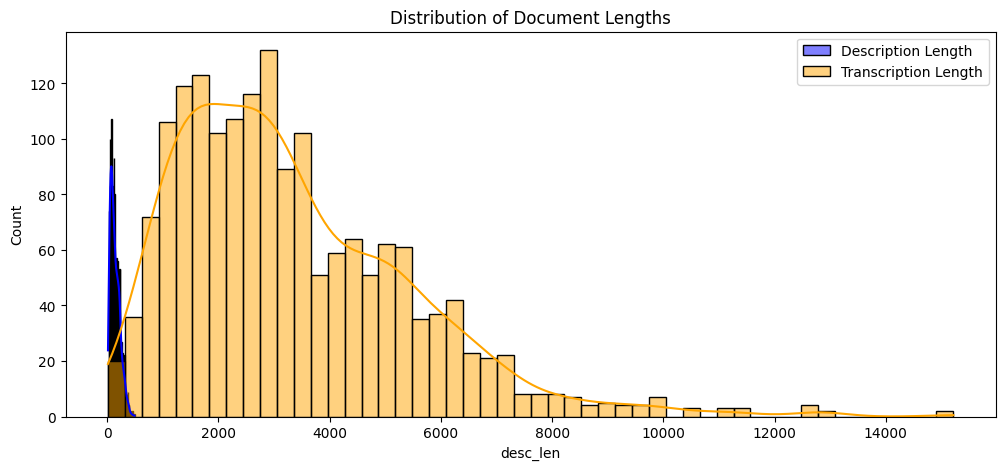

In [24]:
df_train["desc_len"] = df_train["description"].astype(str).apply(len)
df_train["trans_len"] = df_train["transcription"].astype(str).apply(len)

plt.figure(figsize=(12,5))
sns.histplot(df_train["desc_len"], bins=50, kde=True, color="blue", label="Description Length")
sns.histplot(df_train["trans_len"], bins=50, kde=True, color="orange", label="Transcription Length")
plt.legend()
plt.title("Distribution of Document Lengths")
plt.show()


C:\Users\pasin\AppData\Local\Temp\ipykernel_1908\2648289343.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df_train["medical_specialty"], order=df_train["medical_specialty"].value_counts().index, palette="viridis")


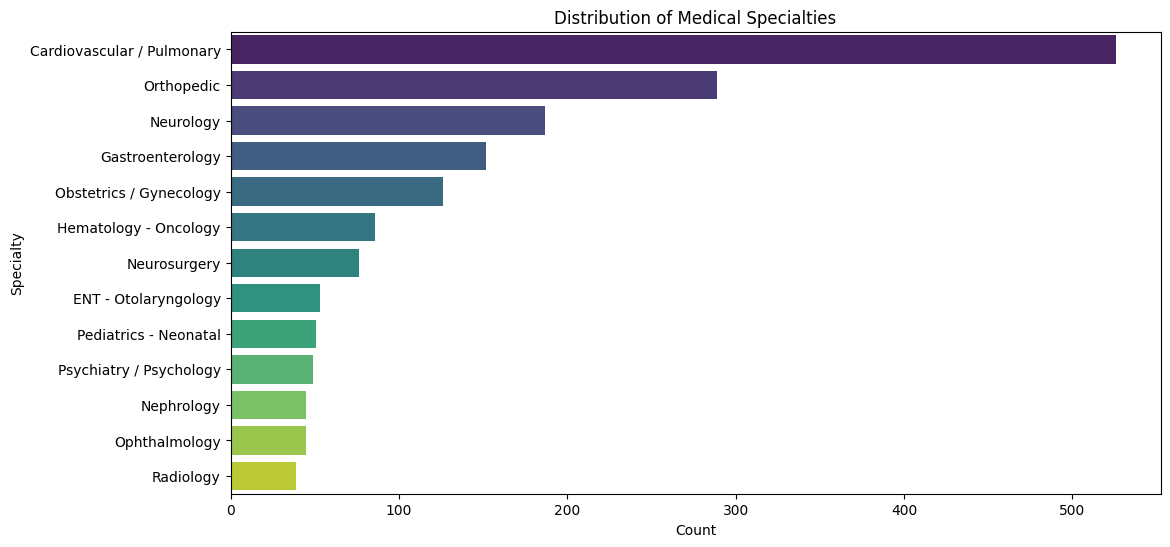

In [25]:
plt.figure(figsize=(12,6))
sns.countplot(y=df_train["medical_specialty"], order=df_train["medical_specialty"].value_counts().index, palette="viridis")
plt.title("Distribution of Medical Specialties")
plt.xlabel("Count")
plt.ylabel("Specialty")
plt.show()


In [26]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(
        lowercase=True,           # Text cleaning
        stop_words='english',     # Remove common words
        ngram_range=(1,2),        # Unigrams + bigrams for context
        max_features=10000        # Limit features for efficiency
    )),
    ('clf', LogisticRegression(max_iter=1000))
])

# Train
pipeline.fit(df_train["transcription"], df_train["medical_specialty"])

# Evaluate
val_acc = pipeline.score(df_validation["transcription"], df_validation["medical_specialty"])
test_acc = pipeline.score(df_test["transcription"], df_test["medical_specialty"])

print(f"📊 Validation Accuracy: {val_acc:.4f}")
print(f"📊 Test Accuracy: {test_acc:.4f}")


📊 Validation Accuracy: 0.7432
📊 Test Accuracy: 0.7838


In [27]:
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(stop_words='english', lowercase=True)),
    ('clf', LogisticRegression(
        multi_class='multinomial',  # Softmax regression
        solver='lbfgs',
        max_iter=1000
    ))
])

# -----------------------------
# Step 2: Cross-Validation
# -----------------------------
cv_scores = cross_val_score(pipeline, df_train['transcription'], df_train['medical_specialty'], cv=5, scoring='accuracy')
print(f"📊 Cross-Validation Accuracy: {cv_scores.mean():.4f} (+/- {cv_scores.std():.4f})")

# -----------------------------
# Step 3: Hyperparameter Tuning (GridSearch)
# -----------------------------
param_grid = {
    'tfidf__ngram_range': [(1,1), (1,2)],  # unigrams vs bigrams
    'clf__C': [0.01, 0.1, 1, 10]           # regularization strength
}

grid = GridSearchCV(pipeline, param_grid, cv=3, scoring='accuracy', n_jobs=-1, verbose=2)
grid.fit(df_train['transcription'], df_train['medical_specialty'])

print("✅ Best Parameters:", grid.best_params_)
print(f"📊 Best CV Accuracy: {grid.best_score_:.4f}")

# -----------------------------
# Step 4: Evaluate on Validation & Test Sets
# -----------------------------
best_model = grid.best_estimator_

val_acc = best_model.score(df_validation['transcription'], df_validation['medical_specialty'])
test_acc = best_model.score(df_test['transcription'], df_test['medical_specialty'])

print(f"📊 Validation Accuracy (best model): {val_acc:.4f}")
print(f"📊 Test Accuracy (best model): {test_acc:.4f}")


C:\Users\pasin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\pasin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(
C:\Users\pasin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in versio

📊 Cross-Validation Accuracy: 0.7529 (+/- 0.0124)
Fitting 3 folds for each of 8 candidates, totalling 24 fits


C:\Users\pasin\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\linear_model\_logistic.py:1272: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


✅ Best Parameters: {'clf__C': 10, 'tfidf__ngram_range': (1, 1)}
📊 Best CV Accuracy: 0.7871
📊 Validation Accuracy (best model): 0.7784
📊 Test Accuracy (best model): 0.7757


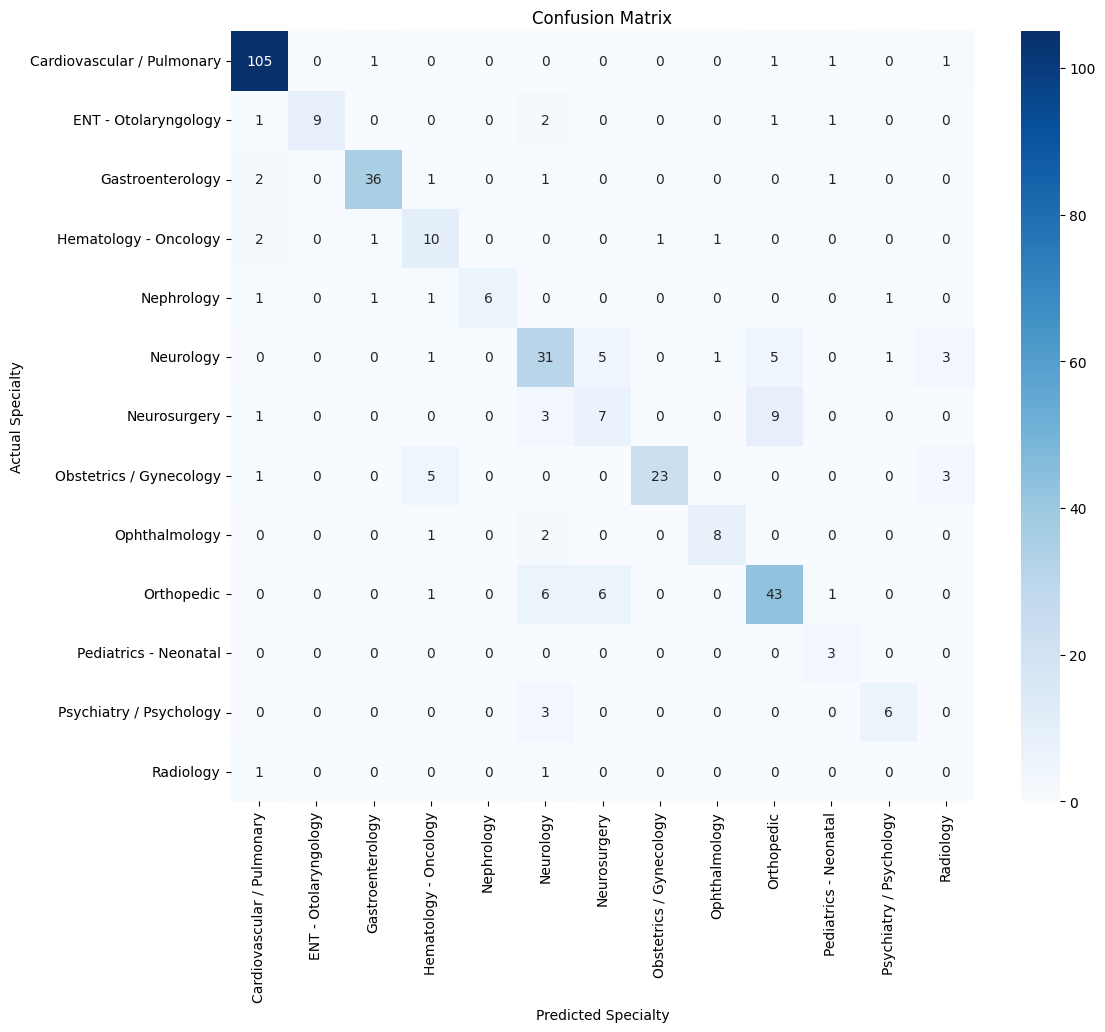

In [28]:
from sklearn.metrics import confusion_matrix, classification_report

y_test_pred = best_model.predict(df_test['transcription'])
y_test_true = df_test['medical_specialty']

cm = confusion_matrix(y_test_true, y_test_pred, labels=best_model.classes_)

# Plot heatmap
plt.figure(figsize=(12,10))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=best_model.classes_,
            yticklabels=best_model.classes_)
plt.ylabel("Actual Specialty")
plt.xlabel("Predicted Specialty")
plt.title("Confusion Matrix")
plt.show()

In [29]:
report = classification_report(y_test_true, y_test_pred, target_names=best_model.classes_)
print("📄 Classification Report:\n", report)

📄 Classification Report:
                             precision    recall  f1-score   support

Cardiovascular / Pulmonary       0.92      0.96      0.94       109
      ENT - Otolaryngology       1.00      0.64      0.78        14
          Gastroenterology       0.92      0.88      0.90        41
     Hematology - Oncology       0.50      0.67      0.57        15
                Nephrology       1.00      0.60      0.75        10
                 Neurology       0.63      0.66      0.65        47
              Neurosurgery       0.39      0.35      0.37        20
   Obstetrics / Gynecology       0.96      0.72      0.82        32
             Ophthalmology       0.80      0.73      0.76        11
                Orthopedic       0.73      0.75      0.74        57
     Pediatrics - Neonatal       0.43      1.00      0.60         3
   Psychiatry / Psychology       0.75      0.67      0.71         9
                 Radiology       0.00      0.00      0.00         2

                  ac

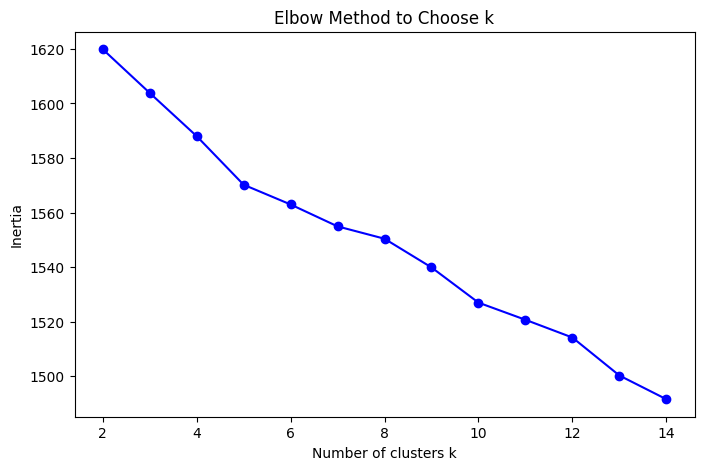

Cluster 0: patient, history, pain, normal, right, does, symptoms, past, time, states
Cluster 1: eye, chamber, lead, lens, anterior chamber, vein, patient, catheter, subclavian, procedure
Cluster 2: history, patient, mg, daily, past, denies, mg daily, normal, disease, pain
Cluster 3: unremarkable, revealed, left, exam, right, 96, 93, 92, weakness, mri
Cluster 4: c5, c6, tendon, placed, patient, c4, c5 c6, medial, right, ligament
Cluster 5: carotid, artery, carotid artery, prolene, internal, cardioplegia, internal carotid, running, bypass, vein
Cluster 6: placed, patient, procedure, tube, incision, right, anesthesia, removed, using, closed
Cluster 7: artery, coronary, left, coronary artery, right, catheter, right coronary, french, stenosis, vessel
Cluster 8: valve, aortic, mitral, normal, regurgitation, aortic valve, tricuspid, left, atrium, ventricular
Cluster 9: procedure, patient, normal, right, left, l5, fetal, lobe, l4, scope


In [30]:
vectorizer = TfidfVectorizer(stop_words='english', lowercase=True, max_features=10000, ngram_range=(1,2))
X_tfidf = vectorizer.fit_transform(df_train['transcription'])

inertia = []
K = range(2, 15)  # try 2–15 clusters
for k in K:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_tfidf)
    inertia.append(km.inertia_)

plt.figure(figsize=(8,5))
plt.plot(K, inertia, 'bo-')
plt.xlabel("Number of clusters k")
plt.ylabel("Inertia")
plt.title("Elbow Method to Choose k")
plt.show()

k = 10
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(X_tfidf)

# Cluster labels for each document
clusters = kmeans.labels_
df_train['cluster'] = clusters

terms = vectorizer.get_feature_names_out()

for i in range(k):
    cluster_center = kmeans.cluster_centers_[i]
    top_idx = cluster_center.argsort()[-10:][::-1]  # top 10 words
    top_terms = [terms[ind] for ind in top_idx]
    print(f"Cluster {i}: {', '.join(top_terms)}")